In [1]:
import itertools

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [2]:
def make_paired_dataset(X, y):
    """
    Gera um dataset de pares a partir de um conjunto de imagens, com rótulos indicativos de se as imagens no par são da mesma classe.

    Isso é útil para tarefas de aprendizado como verificação de identidade ou correspondência de itens, onde é preciso
    comparar duas entradas e determinar se são semelhantes. Ao gerar todos os possíveis pares de imagens e indicar
    se são da mesma classe, o modelo pode ser treinado para aprender a diferenciar entre 'semelhante' e 'não semelhante'.

    Args:
        X (np.array): Um array de numpy contendo as imagens do dataset.
        y (np.array): Um array de numpy contendo os rótulos das imagens.

    Returns:
        X_pairs (np.array): Um array contendo todos os pares possíveis de imagens.
        y_pairs (np.array): Um array de rótulos binários, onde 1 representa pares de imagens da mesma classe e
                            0 representa pares de imagens de classes diferentes.

    Nota:
        A função usa a abordagem de produto cartesiano para gerar pares, o que pode ser muito intensivo em memória.
        Em um dataset grande, considere gerar pares de forma estocástica ou usar um gerador Python para evitar
        uso excessivo de memória.

    Exemplo:
        >> make_paired_dataset(np.array([img1, img2]), np.array([1, 2]))
        (array([[img1, img1], [img1, img2], [img2, img1], [img2, img2]]),
         array([1, 0, 0, 1]))

    Verificar Artigo: https://ieeexplore.ieee.org/document/1467314 - Learning a similarity metric discriminatively, with application to face verification
    """

    # Prepara uma lista para armazenar os pares de imagens e seus rótulos
    X_pairs, y_pairs = [], []

    # Cria uma lista de tuplas, onde cada tupla contém uma imagem e seu respectivo rótulo
    tuples = list(zip(X, y))

    # Gera todos os possíveis pares de imagens usando produto cartesiano
    for (img_A, label_A), (img_B, label_B) in itertools.product(tuples, repeat=2):
        # Adiciona os pares de imagens e o label (1 se os labels forem iguais, 0 caso contrário)
        X_pairs.append([img_A, img_B])
        y_pairs.append(int(label_A == label_B))

    # Converte as listas de pares e rótulos em arrays de numpy para processamento pelo modelo
    return np.array(X_pairs), np.array(y_pairs)


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
# Filtrando apenas as imagens de gatos e cães (classes 3 e 5)
cat_indices = np.where(y_train == 3)[0]
dog_indices = np.where(y_train == 5)[0]
x_cat = x_train[cat_indices]
x_dog = x_train[dog_indices]
y_cat = np.zeros(len(cat_indices))
y_dog = np.ones(len(dog_indices))

In [6]:
# Concatenando as imagens e os rótulos
x_train = np.concatenate([x_cat, x_dog], axis=0)
y_train = np.concatenate([y_cat, y_dog], axis=0)

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000,), (10000, 32, 32, 3), (10000, 1))

In [8]:
#-------------------
# Filtrando apenas as imagens de gatos e cães (classes 3 e 5)
cat_indices = np.where(y_test == 3)[0]
dog_indices = np.where(y_test == 5)[0]
x_cat = x_test[cat_indices]
x_dog = x_test[dog_indices]
y_cat = np.zeros(len(cat_indices))
y_dog = np.ones(len(dog_indices))

# Concatenando as imagens e os rótulos
# Imagens e rótulos selecionados são concatenados para formar o conjunto de treinamento final.
x_test = np.concatenate([x_cat, x_dog], axis=0)
y_test = np.concatenate([y_cat, y_dog], axis=0)
#-------

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000,), (2000, 32, 32, 3), (2000,))

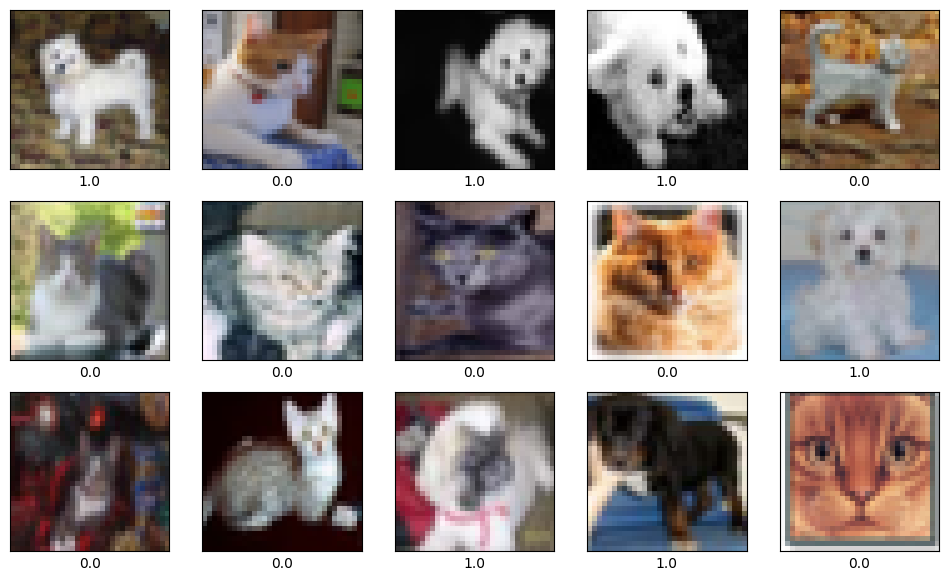

In [10]:
def visualize_random_images(x_train, y_train, num_images=15):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        index = random.randint(0, len(x_train) - 1)
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[index])
        plt.xlabel(y_train[index])
    plt.show()

visualize_random_images(x_train, y_train)

In [11]:
# Redimensionamento das imagens para o tamanho esperado pela Xception (71x71)
x_train = np.array([img_to_array(array_to_img(im, scale=False).resize((71, 71))) for im in x_train])
x_test = np.array([img_to_array(array_to_img(im, scale=False).resize((71, 71))) for im in x_test])

In [12]:
from tensorflow.keras.applications.xception import preprocess_input
from keras import backend as K

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [13]:
# Imprimir os valores normalizados
print("Valores normalizados de x_train:")
print(x_train)

print("\nValores normalizados de x_test:")
print(x_test)

Valores normalizados de x_train:
[[[[-0.02745098 -0.01960784 -0.09019607]
   [-0.05098039 -0.05882353 -0.1372549 ]
   [-0.10588235 -0.15294117 -0.23137254]
   ...
   [ 0.5764706   0.6156863   0.67058825]
   [ 0.58431375  0.6313726   0.6784314 ]
   [ 0.58431375  0.6313726   0.6784314 ]]

  [[-0.00392157  0.01176476 -0.05882353]
   [-0.01960784 -0.02745098 -0.09019607]
   [-0.06666666 -0.09803921 -0.17647058]
   ...
   [ 0.58431375  0.62352943  0.6784314 ]
   [ 0.5921569   0.6392157   0.6862745 ]
   [ 0.5921569   0.6392157   0.6862745 ]]

  [[ 0.04313731  0.06666672  0.0196079 ]
   [ 0.04313731  0.05098045  0.00392163]
   [ 0.02745104  0.0196079  -0.03529412]
   ...
   [ 0.6         0.6627451   0.7019608 ]
   [ 0.6156863   0.6784314   0.7176471 ]
   [ 0.62352943  0.6862745   0.7254902 ]]

  ...

  [[-0.18431371 -0.35686272 -0.6784314 ]
   [-0.18431371 -0.35686272 -0.6784314 ]
   [-0.17647058 -0.34117645 -0.6784314 ]
   ...
   [ 0.09803927 -0.09803921 -0.3490196 ]
   [ 0.09803927 -0.10588

In [14]:
x_train.shape

(10000, 71, 71, 3)

In [15]:
# Definindo a arquitetura da rede siamesa
def create_siamese_network(input_shape):
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)

    # Ramo esquerdo da rede
    base_model = Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(71, 71, 3),
        pooling='avg'
    )

# Freezing layers
    for layer in base_model.layers:
        layer.trainable = False

    # Branches
    left_branch = base_model(input_image1)
    right_branch = base_model(input_image2)

    # Euclidean distance
    # distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_branch, right_branch])

    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([left_branch, right_branch])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    model = Model(inputs=[input_image1,input_image2],outputs=prediction)

    # Final dense layer
    # output = Dense(1, activation='sigmoid')(distance)

    # Siamese model assembly
    # model = Model(inputs=[input_image1, input_image2], outputs=output)

    return model

In [16]:
# Criando a rede siamesa
input_shape = x_train.shape[1:]
siamese_network = create_siamese_network(input_shape)
print(input_shape)

83683744/83683744 [==============================] - 1s 0us/step
(71, 71, 3)


In [17]:
x_train.shape[0]** 2

100000000

In [18]:
# Seleção aleatória de exemplos do dataset para criar pares
random_indices = np.random.choice(x_train.shape[0], 150, replace=False)
x_train_sample, y_train_sample = x_train[random_indices], y_train[random_indices]
x_train_sample.shape, y_train_sample.shape


((150, 71, 71, 3), (150,))

In [19]:
# Seleção aleatória de exemplos do dataset para criar pares
random_indices = np.random.choice(x_test.shape[0], 100, replace=False)
# Aplicando a função para criar os datasets de teste
x_test_sample, y_test_sample = x_test[random_indices], y_test[random_indices]
x_test_sample.shape, y_test_sample.shape


((100, 71, 71, 3), (100,))

In [20]:
# Aplicando a função para criar os datasets de teste
x_test_pairs, y_test_pairs = make_paired_dataset(x_test_sample, y_test_sample)
x_test_pairs.shape, y_test_pairs.shape


((10000, 2, 71, 71, 3), (10000,))

In [21]:
# Aplicando a função para criar os datasets de treino
x_train_pairs, y_train_pairs = make_paired_dataset(x_train_sample, y_train_sample)
x_train_pairs.shape, y_train_pairs.shape


((22500, 2, 71, 71, 3), (22500,))

In [22]:
# Aplicando a função para criar os datasets de treino
x_test_pairs, y_test_pairs = make_paired_dataset(x_test_sample, y_test_sample)
x_test_pairs.shape, y_test_pairs.shape


((10000, 2, 71, 71, 3), (10000,))

In [23]:
# Compilando o modelo
siamese_network.compile(optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 xception (Functional)       (None, 2048)                 2086148   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 2048)                 0         ['xception[0][0]',        

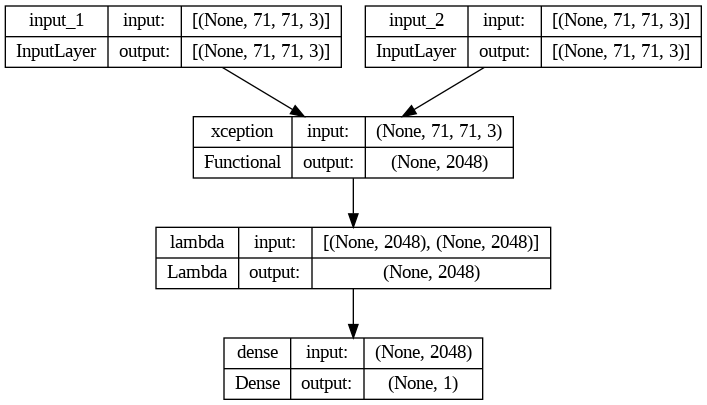

In [24]:
from tensorflow.keras.utils import plot_model

siamese_network.summary()
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [25]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 7.2 MB/s eta 0:00:00


In [26]:
from tensorflow.keras.utils import plot_model
# from keras_visualizer import visualizer
import visualkeras

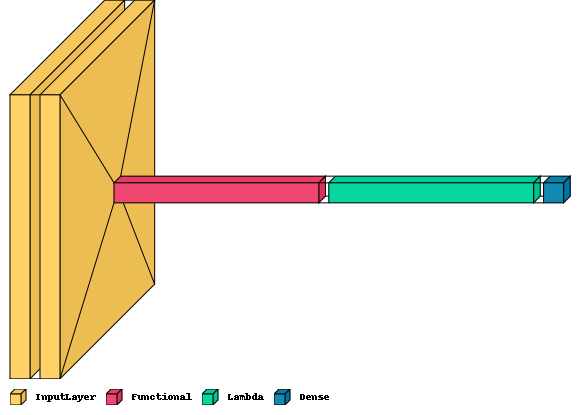

In [27]:

visualkeras.layered_view(siamese_network, legend=True)


In [28]:
x_train_pairs.shape

(22500, 2, 71, 71, 3)

In [29]:
history = siamese_network.fit(x=[ x_train_pairs[:, 0, :, :],
                                  x_train_pairs[:, 1, :, :]],
                                  y=y_train_pairs,
                                  validation_data=([x_test_pairs[:, 0, :, :],
                                                    x_test_pairs[:, 1, :, :]],
                                                    y_test_pairs),
                                  epochs=20,
                                  batch_size=32)


Epoch 1/20
704/704 [==============================] - 68s 69ms/step - loss: 0.7020 - accuracy: 0.5698 - val_loss: 0.7694 - val_accuracy: 0.5344
Epoch 2/20
704/704 [==============================] - 52s 74ms/step - loss: 0.6283 - accuracy: 0.6508 - val_loss: 0.7967 - val_accuracy: 0.5366
Epoch 3/20
704/704 [==============================] - 45s 64ms/step - loss: 0.5905 - accuracy: 0.6874 - val_loss: 0.8218 - val_accuracy: 0.5380
Epoch 4/20
704/704 [==============================] - 53s 75ms/step - loss: 0.5703 - accuracy: 0.7024 - val_loss: 0.8556 - val_accuracy: 0.5484
Epoch 5/20
704/704 [==============================] - 53s 75ms/step - loss: 0.5565 - accuracy: 0.7131 - val_loss: 0.8952 - val_accuracy: 0.5454
Epoch 6/20
704/704 [==============================] - 53s 75ms/step - loss: 0.5455 - accuracy: 0.7228 - val_loss: 0.9538 - val_accuracy: 0.5432
Epoch 7/20
704/704 [==============================] - 53s 75ms/step - loss: 0.5378 - accuracy: 0.7266 - val_loss: 1.0164 - val_accuracy:

In [ ]:
# Avaliação do modelo nos dados de teste
y_pred = siamese_network.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]])
y_pred = (y_pred > 0.5).astype(int)

In [ ]:
print(classification_report(y_test_pairs, y_pred, target_names=['Different', 'Same']))


In [ ]:
# Treinando o modelo
# siamese_network.fit([x_train, x_train], y_train, epochs=10, batch_size=16, validation_data=([x_test, x_test], y_test))